# Nonrigid alignment of Spateo alignment for 2D slices

In this tutorial, we will introduce the 

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running this notebook on: ", device)

import spateo as st
print("Last run with spateo version:", st.__version__)

# Other imports
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import numpy as np

# Uncomment the following if running on the server
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

Running this notebook on:  cuda


2024-08-14 22:00:47.850582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 22:00:48.036375: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-14 22:00:48.036404: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-14 22:00:48.825416: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Last run with spateo version: 1.0.2.dev519+46c6d93.dirty


(EE) 
Fatal server error:
(EE) Server is already active for display 99
	If this server is no longer running, remove /tmp/.X99-lock
	and start again.
(EE) 


# Load the data

The data used in this tutorial can be downloaded using the following links:

Mouse embryo E95 slice #32: https://drive.google.com/file/d/16gh_vApgzlvrplzbxYe-eODjZhvdNM4Z/view?usp=drive_link

Mouse embryo E95 slice #33: https://drive.google.com/file/d/16gh_vApgzlvrplzbxYe-eODjZhvdNM4Z/view?usp=drive_link

Adult mouse central nervous system from STARMap Plus dataset sagittal #3: https://drive.google.com/file/d/1kaeBK1xEc-AuKNUPgBaYTKc7si_7WASW/view?usp=drive_link

In [2]:
# Load the STARMap Plus slice
adata = st.read('./data/sagittal3.h5ad')

adata

AnnData object with n_obs × n_vars = 207591 × 1022
    obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type'
    uns: 'Main_molecular_tissue_region_palette'
    obsm: 'spatial', 'spatial_raw'

# Visualize the data in 3D

<div class="alert alert-warning">
Warning
    
Before you run the pyvista based visualization function "st.pl.three_d_plot", please check you have instailled pyvista correctly, especially for server. Otherwise, it may cause jupyter notebook to crash. We recommend the user to check the pyvista instailation tutorial. 
    
</div>

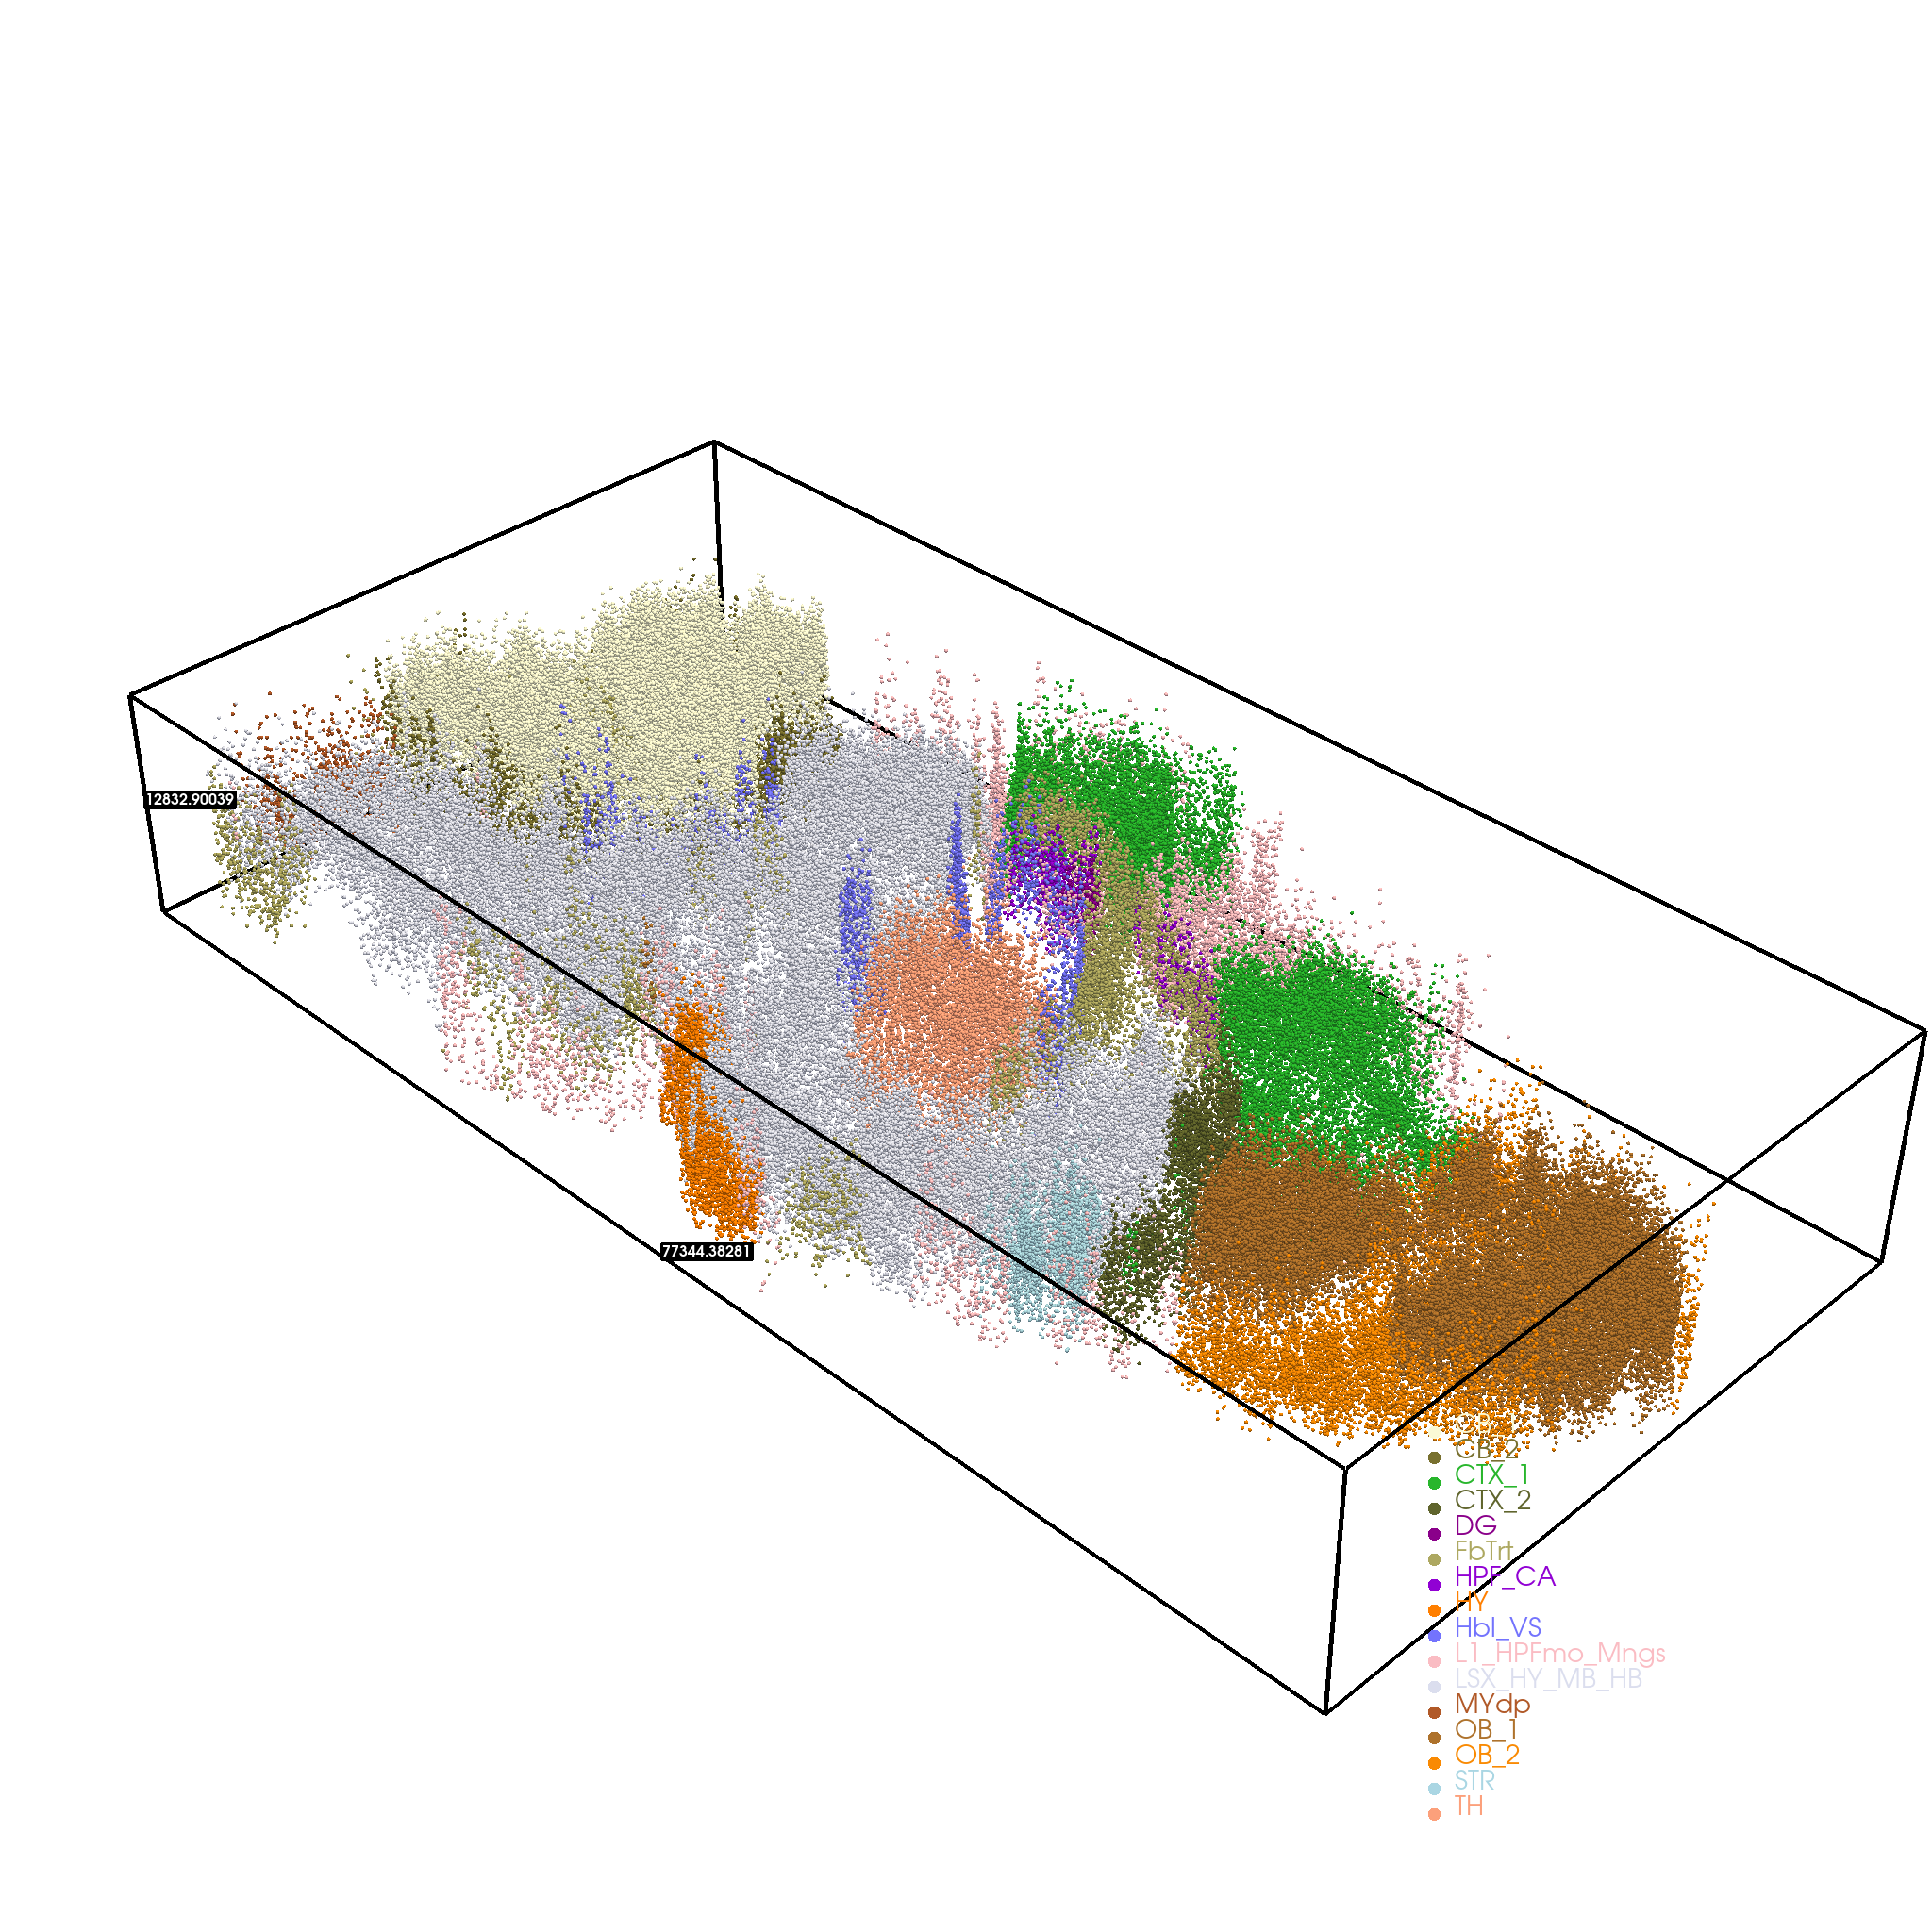

In [3]:
# define the palette
palette = adata.uns['Main_molecular_tissue_region_palette']

point_cloud, _ = st.tdr.construct_pc(adata=adata,spatial_key="spatial_raw",groupby="Main_molecular_tissue_region",key_added="tissue",colormap=palette,)

# make the z height bigger
point_cloud.points[:,2] *= 500

# show the STARMap Plus slice in 3D
st.pl.three_d_plot(
    model=point_cloud,
    key="tissue",
    model_style='points',
    model_size=4,
    jupyter="static",
    window_size=(2048, 2048),
    ambient=0.2,
    cpo='iso',
    show_outline=True,
)


# Cut pesudo slices

In [4]:
import sys
sys.path.insert(0, "/home/ylu/project")
from utils import *

In [5]:
# slices = st.align.split_slice(adata=adata,spatial_key='spatial_raw',split_num=4,axis=2,)
slices = split_slice(adata=adata,spatial_key='spatial_raw',split_num=4,axis=2,)

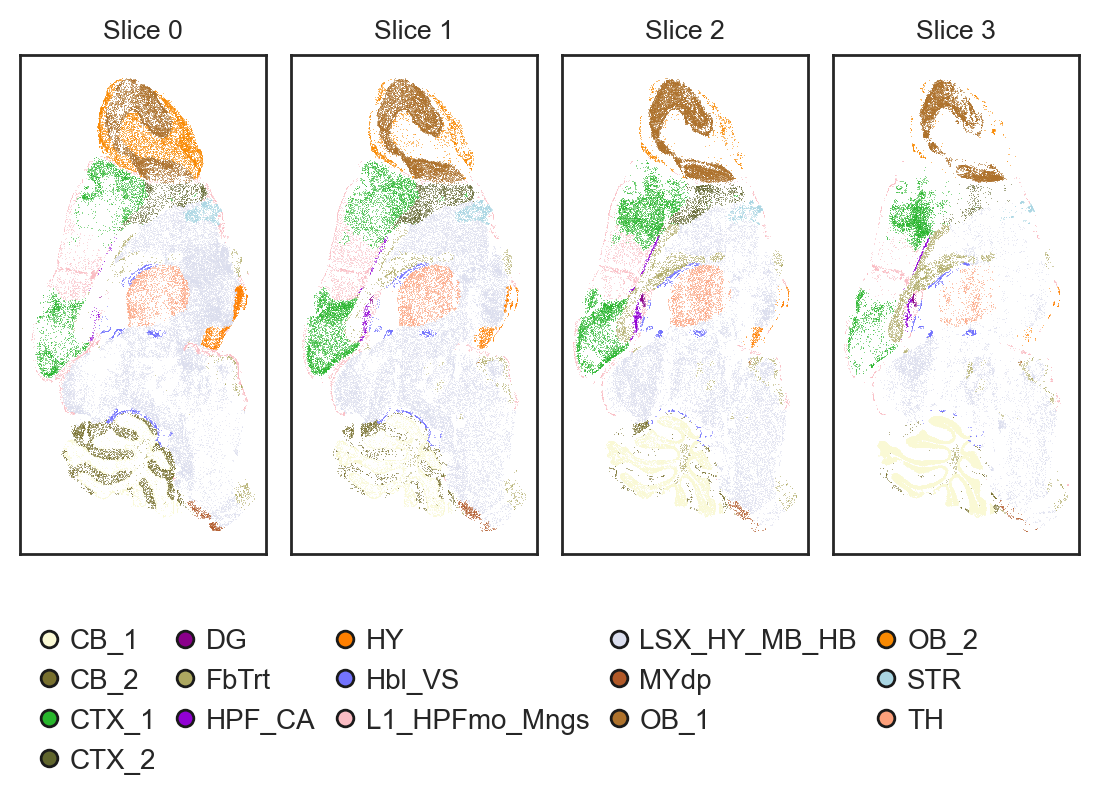

In [6]:
spatial_key = 'spatial_raw'
cluster_key = 'Main_molecular_tissue_region'

st.pl.slices_2d(
    slices = slices,
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=False,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    palette=palette,
)

# Perform thin-plate-spine distortion to generate simulated nonrigid deformation

In [26]:
slice1 = slices[0].copy()
slice2 = slices[1].copy()
tps_f = tps_deformation(
    adata=slice2,
    spatial_key='spatial',
    key_added='tps_spatial',
    grid_num=2,
    tps_noise_scale=0.15,
)
slice1.obsm['tps_spatial'] = slice1.obsm['spatial'].copy()

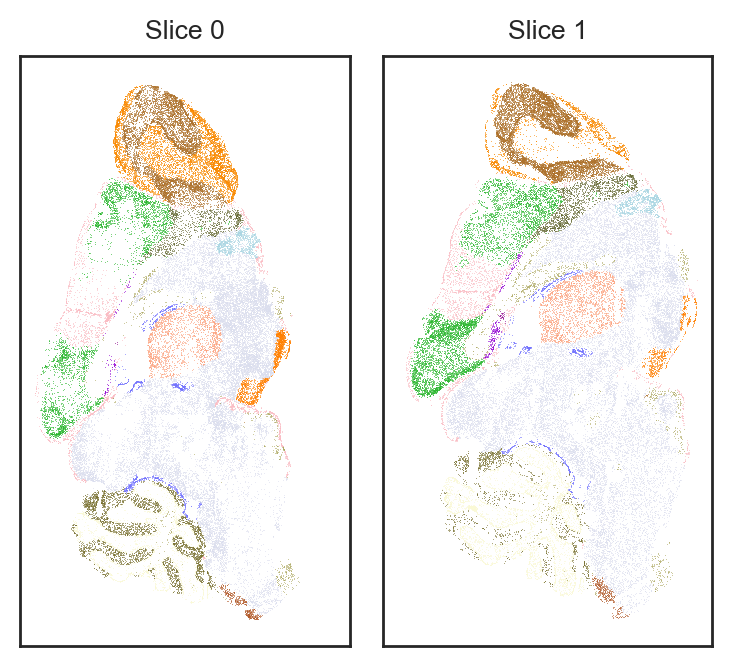

In [27]:
spatial_key = 'tps_spatial'
cluster_key = 'Main_molecular_tissue_region'

st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=False,
    show_legend=False,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    palette=palette,
)

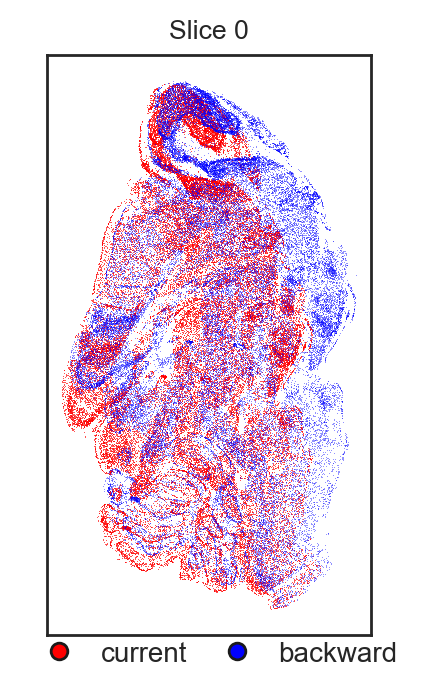

In [28]:
slice2_original = slice2.copy()
slice2_original.obsm['tps_spatial'] = slice2_original.obsm['spatial'].copy()
st.pl.overlay_slices_2d(slices = [slice2_original, slice2], spatial_key = 'tps_spatial', height=4, overlay_type='backward')

# Spateo alignment

In [29]:
key_added = 'align_spatial'
spatial_key = 'tps_spatial'
# spateo return aligned slices as well as the mapping matrix
aligned_slices, pis = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    beta=1e-2,  # default setting
    lambdaVF=1e2,  # default setting
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([21867.0078, 21867.0078])...
|-----------> Scale: tensor([[23801.4453, 43931.3984],
        [22175.2773, 41677.4531]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [20.1618s]
|-----> Key Parameters: gamma: 0.9900000095367432; sigma2: 0.0035609083715826273; probability_parameters: [tensor(0.3333, device='cuda:0')]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [0.9001s]


The default output in "key_added" is the rigid, which is 

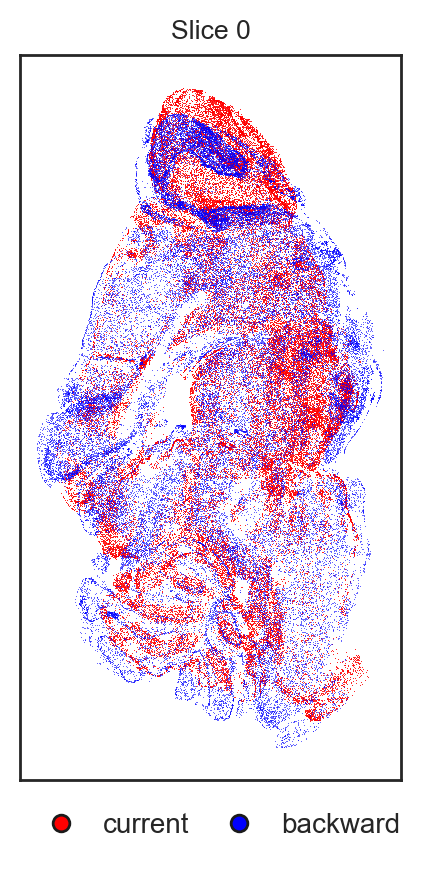

In [30]:
# Visualize the alignment results
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added, height=5, overlay_type='backward')

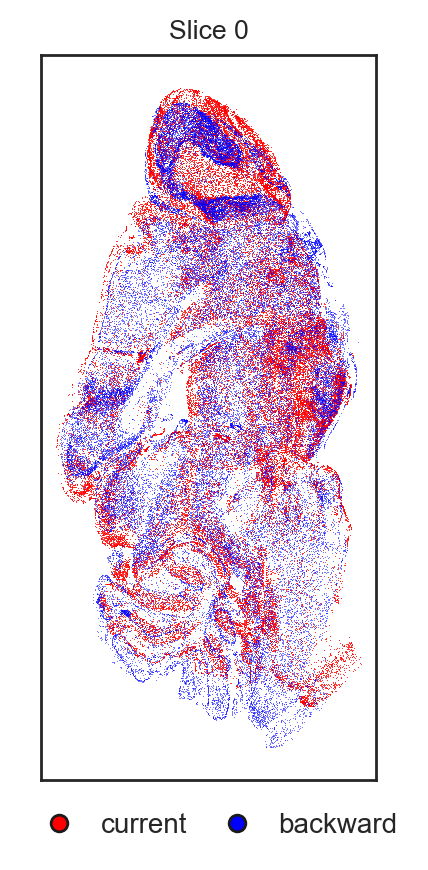

In [31]:
# Visualize the alignment results
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added+'_nonrigid', height=5, overlay_type='backward')

In [41]:
key_added = 'align_spatial'
spatial_key = 'tps_spatial'
# spateo return aligned slices as well as the mapping matrix
aligned_slices, pis = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    beta=1,
    lambdaVF=10,
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([21867.0078, 21867.0078])...
|-----------> Scale: tensor([[23801.4453, 43931.3984],
        [22175.2773, 41677.4531]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [19.4868s]
|-----> Key Parameters: gamma: 0.9900000095367432; sigma2: 0.0017173470696434379; probability_parameters: [tensor(0.3341, device='cuda:0')]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [0.8805s]


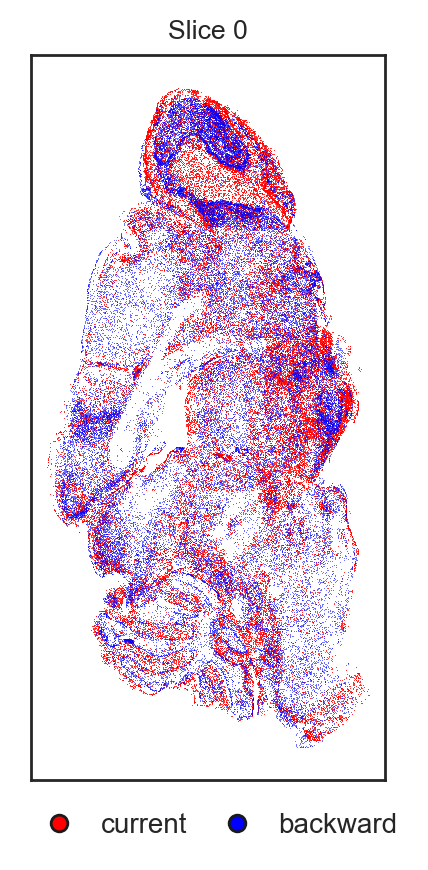

In [42]:
# Visualize the alignment results
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added+'_nonrigid', height=5, overlay_type='backward')

<div class="alert alert-info">
Note
    
There are many factors can affect the non-rigid results. The most important ones are three:

- beta: 

- lambdaVF: 

- representation features: 
    
</div>

<div class="alert alert-warning">
Warning
    
Although nonrigid alignment is better for aligning local structures, it may not always be the best choice in 3D reconstruction. This is because consecutive slices are inherently different, and we can't in fact tell whether the deformation of a slice is due to distortions caused at the time of slicing or from the original structure. To this end, we have a tutorial for user to determine when to use the nonrigid alignment in 3D reconstruction.

When to use nonrigid in 3D reconstruction: xxx
    
</div>